In [2]:
# ===============****===================
"""
Monthly Water Use Model
Date: 7/14/2022

"""
# ===============****===================


import os
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from flopy.plot import styles

from xgboost import plot_importance
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

from iwateruse.model import Model
from iwateruse import targets, weights, pipelines, outliers_utils, estimators, featurize
from iwateruse import selection
from iwateruse import data_cleaning, report, splittors, pre_train_utils, make_dataset, figures
from iwateruse import denoise, model_diagnose
from pycaret.regression import *

warnings.filterwarnings('ignore')
xgb.set_config(verbosity=0)

# =============================
# Flags
#==============================
train_initial_model = True
run_boruta = False
use_boruta_results = True
run_permutation_selection = False
run_chi_selection = False
run_RFECV_selection = False

# =============================
# Setup Training
# =============================
figures_folder = "figs"
model = Model(name='monthly_pc', log_file='train_log_monthly_pycaret.log', feature_status_file=r"..\features_status.xlsx",
              model_type = 'monthly')
model.raw_target = 'monthly_wu'
model.target = 'monthly_fraction'

datafile = r"..\clean_train_db_monthly.csv"  # clean_train_db_backup_6_24_2022.csv
df_train = pd.read_csv(datafile)
model.add_training_df(df_train=df_train)

seed1 = 123
seed2 = 456

opts = ['monthly_fraction>0.18', 'monthly_fraction<0.03', 'simil_stat<0.7']
model.apply_func(func=outliers_utils.drop_values, type='outliers_func', opts=opts)
model.apply_func(func=outliers_utils.drop_na_target, type='outliers_func')

# =============================
# Feature Engineering
# =============================
# Target summary
tr_df, cat_df = featurize.summary_encode(model, cols=model.categorical_features)
df_concat = pd.concat([tr_df, cat_df], axis=1)
model.add_feature_to_skip_list(model.categorical_features)
model.add_training_df(df_train=df_concat)
del (tr_df);
del (cat_df);
del (df_concat)

# =============================
# Prepare the initial estimator
# =============================

"""
tree_method = 'hist', n_estimators=600, learning_rate=0.06,
                      max_depth=10, subsample=0.85, colsample_bytree=0.9, verbosity=0,  rate_drop=0.1,  alpha=0, 
                      seed = 123,  skip_drop=0.5, gamma = 0
                      """

params = {
    'objective': "reg:squarederror",
    'tree_method': 'hist',
    'colsample_bytree': 0.9,#
    'learning_rate': 0.06, #
    'max_depth': 10,#
    'alpha': 0.0, #
    'n_estimators': 600, #
    'rate_drop': 0.1,#
    'skip_drop': 0.5,#
    'subsample': 0.85,#
    'reg_lambda': 1,
    'min_child_weight': 1,
    'gamma': 0,#
    'max_delta_step': 0,
    'seed': seed2
}

gb = estimators.xgb_estimator(params)

encode_cat_features = False
if encode_cat_features:
    # pipeline
    main_pipeline = pipelines.make_pipeline(model)
    main_pipeline.append(('estimator', gb))
    gb = Pipeline(main_pipeline)



# =============================
# Prepare the initial estimator
# =============================
confirmed_features = ['Year', 'pop_density', 'gini', 'n_industry', 'median_income',
       'median_h_year', 'HUC2_50', 'HUC2_75', 'LAT', 'LONG', 'county_id_5',
       'county_id_25', 'county_id_50', 'county_id_75', 'county_id_95',
       'awuds_pop_cnt', 'zill_nhouse', 'LotSizeSquareFeet_sum',
       'YearBuilt_mean', 'BuildingAreaSqFt_sum', 'TaxAmount_mean',
       'NoOfStories_mean', 'bdg_ftp_count', 'bdg_gt_2median', 'bdg_lt_2median',
       'bdg_lt_4median', 'av_house_age', 'n_houses', 'average_income',
       'state_id_5', 'state_id_25', 'state_id_50', 'state_id_95', 'Commercial',
       'Domestic', 'Urban_Misc', 'Production', 'Water', 'WSA_SQKM',
       'KG_climate_zone_5', 'KG_climate_zone_75', 'KG_climate_zone_95',
       'prc_n_lt_ninth_gr', 'prc_n_ninth_to_twelth_gr', 'prc_n_hs_grad',
       'prc_n_bachelors', 'prc_n_masters_phd', 'pop', 'cii_frac', 'etr', 'pr',
       'pr_cumdev', 'tmmn', 'tmmx']

# features_to_drop = set(features).difference(confirmed_features)
# model.add_feature_to_skip_list(list(features_to_drop))
# features = model.features
features = confirmed_features #model.features
target = model.target
final_dataset = model.df_train
ignore_features = list(set(final_dataset.columns).difference(set(features + [target])))


In [4]:
# =============================
# Prepare the initial estimator
# =============================

reg1 = setup(data = final_dataset, target = target, ignore_features = ignore_features,
             fold=5, fold_shuffle = True,
             train_size = 0.7)

,Description,Value
0,session_id,8774
1,Target,monthly_fraction
2,Original Data,"(132347, 121)"
3,Missing Values,True
4,Numeric Features,54
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(92642, 54)"


In [5]:
xgb = create_model('xgboost', **params)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0078,0.0001,0.0116,0.8139,0.0105,0.1001
1,0.0077,0.0001,0.0113,0.8181,0.0103,0.0991
2,0.0078,0.0001,0.0114,0.8212,0.0104,0.1003
3,0.0077,0.0001,0.0113,0.8214,0.0103,0.0991
4,0.0079,0.0001,0.0117,0.8066,0.0107,0.1018
Mean,0.0078,0.0001,0.0114,0.8162,0.0104,0.1001
Std,0.0001,0.0000,0.0002,0.0055,0.0001,0.0010


In [6]:
tuned_xgb= tune_model(xgb, fold = 5, search_library = 'scikit-optimize',
                      search_algorithm = 'bayesian', n_iter = 100)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0079,0.0001,0.0116,0.8126,0.0106,0.1019
1,0.0078,0.0001,0.0113,0.8170,0.0104,0.1007
2,0.0079,0.0001,0.0114,0.8212,0.0104,0.1015
3,0.0079,0.0001,0.0113,0.8190,0.0104,0.1012
4,0.0080,0.0001,0.0117,0.8065,0.0107,0.1031
Mean,0.0079,0.0001,0.0115,0.8153,0.0105,0.1017
Std,0.0001,0.0000,0.0001,0.0052,0.0001,0.0008


In [7]:
tuned_xgb

XGBRegressor(alpha=0.0, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.5000321556607336, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.07557887578017972,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=11,
             max_leaves=0, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=-1,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=8774, ...)

In [ ]:
df_xgb = pd.DataFrame.from_dict(tuned_xgb.get_params(), orient = 'index')
df_xgb.to_csv("monthly_xgb_tune.csv")
df_xgb

In [9]:
tuned_xgb.get_params()
"""
{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.5000321556607336,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.07557887578017972,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 11,
 'max_leaves': 0,
 'min_child_weight': 4,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 300,
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 8774,
 'reg_alpha': 0.10344751482933973,
 'reg_lambda': 1e-10,
 'sampling_method': 'uniform',
 'scale_pos_weight': 50.0,
 'subsample': 0.9897842920753088,
 'tree_method': 'hist',
 'validate_parameters': 1,
 'verbosity': 0,
 'alpha': 0.0,
 'rate_drop': 0.1,
 'skip_drop': 0.5,
 'seed': 456}
"""

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.5000321556607336,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.07557887578017972,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 11,
 'max_leaves': 0,
 'min_child_weight': 4,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 300,
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 8774,
 'reg_alpha': 0.10344751482933973,
 'reg_lambda': 1e-10,
 'sampling_method': 'uniform',
 'scale_pos_weight': 50.0,
 'subsample': 0.9897842920753088,
 'tree_method': 'hist',
 'validate_parameters': 1,
 'verbosity': 0,
 'alpha': 0.0,
 'rate_drop': 0.1,
 'skip_drop': 0.5,
 'seed': 456}

In [11]:
tuned_params = {'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.5000321556607336,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.07557887578017972,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 11,
 'max_leaves': 0,
 'min_child_weight': 4,
 'monotone_constraints': '()',
 'n_estimators': 300,
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 8774,
 'reg_alpha': 0.10344751482933973,
 'reg_lambda': 1e-10,
 'sampling_method': 'uniform',
 'scale_pos_weight': 50.0,
 'subsample': 0.9897842920753088,
 'tree_method': 'hist',
 'validate_parameters': 1,
 'verbosity': 0,
 'alpha': 0.0,
 'rate_drop': 0.1,
 'skip_drop': 0.5,
 'seed': 456}
xgb = create_model('xgboost', **tuned_params)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0079,0.0001,0.0116,0.8126,0.0106,0.1019
1,0.0078,0.0001,0.0113,0.8170,0.0104,0.1007
2,0.0079,0.0001,0.0114,0.8212,0.0104,0.1015
3,0.0079,0.0001,0.0113,0.8190,0.0104,0.1012
4,0.0080,0.0001,0.0117,0.8065,0.0107,0.1031
Mean,0.0079,0.0001,0.0115,0.8153,0.0105,0.1017
Std,0.0001,0.0000,0.0001,0.0052,0.0001,0.0008


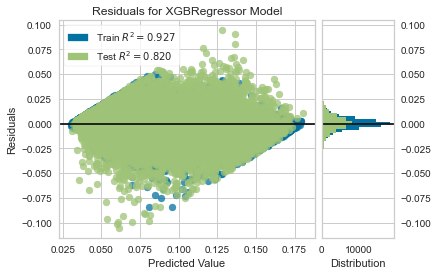

In [12]:
plot_model(xgb)

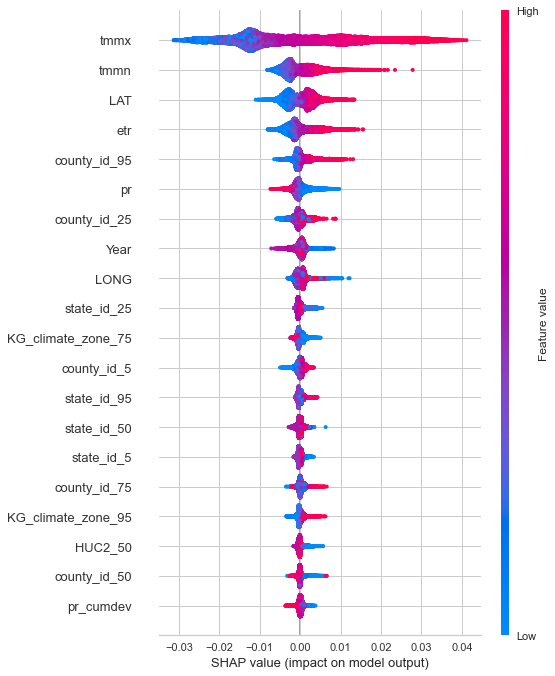

In [13]:
interpret_model(xgb)

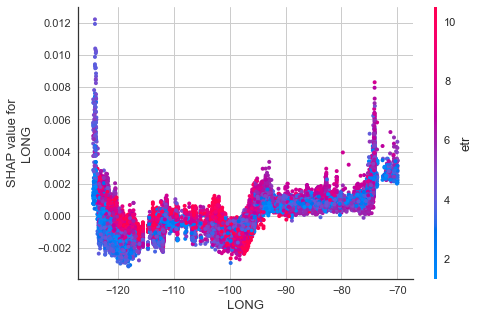

In [15]:
interpret_model(xgb, plot = 'correlation', feature = 'LONG')

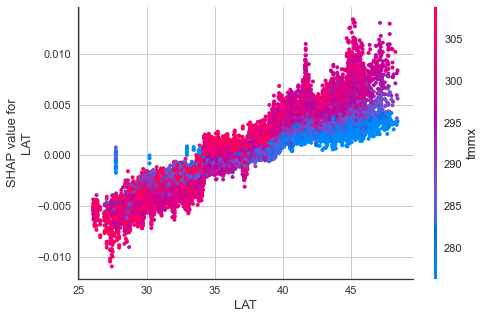

In [16]:
interpret_model(xgb, plot = 'correlation', feature = 'LAT')

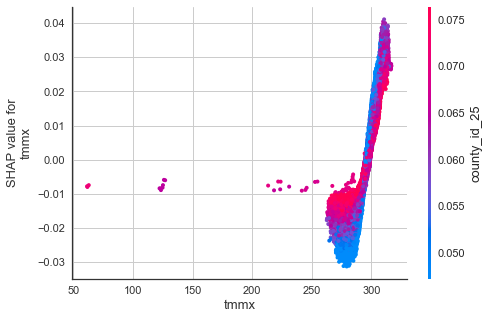

In [17]:
interpret_model(xgb, plot = 'correlation', feature = 'tmmx')

In [ ]:
interpret_model(xgb, plot = 'reason')